# Import

In [2]:
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast

# Import new libraries
import wordcloud
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

# Function that get movie recommendations based on the cosine similarity score of movie genres
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Movie Recommendation Code

In [3]:
def load_movies(movies_file_path, movie_keywords_file_path):
    #Load movies & create movies dataframe
    moviesdf = pd.read_csv(movies_file_path, dtype='unicode')
    #Load movieswithkeywords & create movies dataframe
    moviekeywordsdf = pd.read_csv(movie_keywords_file_path, dtype='unicode')
    
    #convert moviekeywordsdf["id"] datatype from object to int (int64)
    moviekeywordsdf["id"] = moviekeywordsdf["id"].astype(str).astype('int64')
    moviekeywordsdf["keywords"] = moviekeywordsdf["keywords"].astype(str)
    

    #convert each item of release_date to datetime.date type entity
    moviesdf['release_date'] = pd.to_datetime(moviesdf['release_date'], errors='coerce').apply(lambda x: x.date())
    
    moviesdf.drop(moviesdf.index[19730],inplace=True)
    moviesdf.drop(moviesdf.index[29502],inplace=True)
    moviesdf.drop(moviesdf.index[35585],inplace=True)
    moviesdf.reset_index(drop=True, inplace=True)

    #convert moviesdf["id"] datatype from object to int (int64)
    moviesdf["id"] = moviesdf["id"].astype(str).astype('int64')
    
    movies_with_keywords_df = pd.merge(moviesdf,moviekeywordsdf,left_on='id',right_on='id',how='inner')
    
    # all json columns`
    json_columns = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']
    for column in json_columns:
        # use ast because json data has single quotes in the csv, which is invalid for a json object; it should be " normally
        movies_with_keywords_df[column] = movies_with_keywords_df[column].apply(lambda x: np.nan if pd.isnull(x) else ast.literal_eval(x))
    
    
    movies_cbr = pd.DataFrame(columns=[
        'title',
        'genres',
        'genres_list',
        'release_date',
        'budget',
        'revenue',
        'tmdbid',
        'imdbid',
        'runtime',
        'vote_average',
        'vote_count',
        'keywords',
        'keywords_list'
    ])

    for i,movie_row in movies_with_keywords_df.iterrows():
        release_date_year = ''
        try:
            if str( movie_row['release_date'] ) == 'NaT':
                continue
            else:
                release_date_year = ' ( ' + str(movie_row.dropna()['release_date'].year) + ' )'
                release_date = movie_row.dropna()['release_date']
        except TypeError:
            continue
           
        movie_title_new = movie_row['title'] + release_date_year
        if movie_row['revenue'] is not np.nan and movie_row['budget'] is not np.nan:
            budget = movie_row['budget']
            revenue = movie_row['revenue']
        tmdbid = int(movie_row['id'])
        imdbid = movie_row['imdb_id']
        runtime = movie_row['runtime']
        vote_average = movie_row['vote_average']
        vote_count = movie_row['vote_count']
        if movie_row['genres'] is not np.nan and movie_row['keywords'] is not np.nan:
            movie_row_genres_list = []
            movie_row_genres_str = ''
            many_genres = movie_row['genres']
            g = 1
            for one_genre in many_genres:
                if one_genre['name']:
                    movie_row_genres_list.append(one_genre['name'])
                    if g==1:
                        movie_row_genres_str = one_genre['name']
                        g+=1
                    elif g>1:
                        movie_row_genres_str += '|' + one_genre['name']
            
            movie_row_keywords_list = []
            movie_row_keywords_str = ''
            many_keywords = movie_row['keywords']
            k=1
            for one_keyword in many_keywords:
                if one_keyword['name']:
                    movie_row_keywords_list.append(one_keyword['name'])
                    if k==1:
                        movie_row_keywords_str = one_keyword['name']
                        k+=1
                    elif k>1:
                        movie_row_keywords_str += '|' + one_keyword['name']

            movies_cbr = movies_cbr.append({'title':movie_title_new,
                                            'genres':movie_row_genres_str,
                                            'genres_list': movie_row_genres_list,
                                            'release_date' : release_date,
                                            'budget':budget,
                                            'revenue':revenue,
                                            'tmdbid':tmdbid,
                                            'imdbid':imdbid,
                                            'runtime':runtime,
                                            'vote_average':vote_average,
                                            'vote_count':vote_count,
                                            'keywords': movie_row_keywords_str,
                                            'keywords_list': movie_row_keywords_list
                                           },ignore_index=True)
        
    # Convert genres to string value
    movies_cbr['genres'] = movies_cbr['genres'].fillna("").astype('str')
    movies_cbr['release_date'] = pd.to_datetime(movies_cbr['release_date'], errors='coerce').apply(lambda x: x.date())
    movies_cbr = movies_cbr.drop_duplicates(subset='title', keep="first")
    return movies_cbr

def load_movie_ratings(file_path_movie_ratings):
    #Load movieswithratings & create movies dataframe
    df = pd.read_csv(file_path_movie_ratings, dtype='unicode')
    
    #convert df["id"] datatype from object to int (int64)
    df["rating"] = df["rating"].astype(str).astype(float)
    df["movieId"] = df["movieId"].astype(str).astype('int64')
    df["userId"] = df["userId"].astype(str).astype('int64')
    
    return df

def load_expinfo_genre(file_path_expinfo_genre):
    #Load movieswithratings & create movies dataframe
    df = pd.read_csv(file_path_expinfo_genre, dtype='unicode')
    return df


def get_ratings():
    ratingsdf = pd.DataFrame(columns=['userId','movieId','rating','timestamp','scale','sortOrder'])
    for j, rating_row in movieratings.iterrows():
        userid = rating_row['userId']
        movieid = rating_row['movieId']
        rating = rating_row['rating']
        timestamp = rating_row['timestamp']
        scale =''
        sortOrder = 1
        i = float(rating)
        if(i >= 0) and (i <= 1): 
            scale = 'Poor (0-1)'
            sortOrder = 1
        elif(i > 1) and (i <= 2): 
            scale = 'Fair (1-2)'
            sortOrder = 2
        elif(i > 2) and (i <= 3): 
            scale = 'Good (2-3)'
            sortOrder = 3
        elif(i > 3) and (i <= 4): 
            scale = 'Very Good (3-4)'
            sortOrder = 4
        else: 
            scale = 'Excellent (4-5)'
            sortOrder = 5
        ratingsdf = ratingsdf.append({'userId': userid,
                                      'movieId':movieid,
                                      'rating':rating,
                                      'timestamp':timestamp,
                                      'scale':scale,
                                      'sortOrder':sortOrder}, ignore_index = True)
    return ratingsdf

def get_cosine_sim(tfidf_matrix):
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    return cosine_sim

def genre_recommendations(title, cosine_sim,df):  
    # Build a 1-dimensional array with movie titles
    titles = df['title']
    indices = pd.Series(df.index, index=df['title'])
    try:
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:11]
        movie_indices = [i[0] for i in sim_scores]
        return titles.iloc[movie_indices]
    except KeyError:
        return "No recommendations found for this movie"
    
def get_expinfodf_by_genre(movies_cbr_small):
    expinfo_dict_by_genre = {}
    for i in range(movies_cbr_small.shape[0]):
        for genre in str(movies_cbr_small.iloc[i]['genres']).split('|'):
            genre_name = genre
            if genre != 'nan' and genre is not np.nan:
                if movies_cbr_small.iloc[i]['revenue'] is not np.nan and movies_cbr_small.iloc[i]['budget'] is not np.nan and float(movies_cbr_small.iloc[i]['budget']) > 0 and float(movies_cbr_small.iloc[i]['revenue']) > 0.0:
                    total_revenue_mill = round(float(movies_cbr_small.iloc[i]['revenue']) / 1000000,2)
                    total_budget_mill = round(float(movies_cbr_small.iloc[i]['budget']) / 1000000,2)
                else:
                    total_revenue_mill = 0
                    total_budget_mill = 0

                if movies_cbr_small.iloc[i]['runtime'] is not np.nan and float(movies_cbr_small.iloc[i]['runtime']) > 0.0:
                    total_runtime_min = round(float(movies_cbr_small.iloc[i]['runtime']),2)
                else:
                    total_runtime_min = 0

                if genre_name in expinfo_dict_by_genre:
                    expinfo_dict_by_genre[genre_name]['total_revenue_mill'] += total_revenue_mill
                    expinfo_dict_by_genre[genre_name]['total_budget_mill'] += total_budget_mill
                    expinfo_dict_by_genre[genre_name]['movies_count_rb'] += 1
                    expinfo_dict_by_genre[genre_name]['total_runtime_min'] += total_runtime_min
                    expinfo_dict_by_genre[genre_name]['movies_count_rt'] += 1
                    expinfo_dict_by_genre[genre_name]['movies_count_genre'] += 1
                else:
                    expinfo_dict_by_genre[genre_name] = {}
                    expinfo_dict_by_genre[genre_name]['total_revenue_mill'] = total_revenue_mill
                    expinfo_dict_by_genre[genre_name]['total_budget_mill'] = total_budget_mill
                    expinfo_dict_by_genre[genre_name]['movies_count_rb'] = 1
                    expinfo_dict_by_genre[genre_name]['total_runtime_min'] = total_runtime_min
                    expinfo_dict_by_genre[genre_name]['movies_count_rt'] = 1
                    expinfo_dict_by_genre[genre_name]['movies_count_genre'] = 1
    
    expinfodf_by_genre = pd.DataFrame(None,None,columns=[
        'Genre',
        'Movie_Count_Genre',
        'Average_Revenue',
        'Average_Budget',
        'Movies_Count_RB',
        'Average_Runtime',
        'Movies_Count_RT',
    ])

    for k,v in expinfo_dict_by_genre.items():
        expinfodf_by_genre =  expinfodf_by_genre.append({'Genre':k,
                                                         'Movie_Count_Genre': v['movies_count_genre'],
                                                         'Average_Revenue' : round(v['total_revenue_mill']/v['movies_count_rb'],2),
                                                         'Average_Budget' : round(v['total_budget_mill']/v['movies_count_rb'],2),
                                                         'Movies_Count_RB' : v['movies_count_rb'],
                                                         'Average_Runtime' : round(v['total_runtime_min']/v['movies_count_rt'],2),
                                                         'Movies_Count_RT' : v['movies_count_rt']
                                                                  },ignore_index=True)

    return expinfodf_by_genre


def load_preprocess_movies_cbr(movies_cbr_filepath, iscreatecsv=False):
    movies_cbr = pd.read_csv(movies_cbr_filepath, dtype='unicode')
    movies_cbr["tmdbid"] = movies_cbr["tmdbid"].astype(str).astype('int64')
    movies_cbr["imdbid"] = movies_cbr["tmdbid"].astype(str).astype('int64')
    movies_cbr["budget"] = movies_cbr["budget"].astype(str).astype('int64')
    movies_cbr["revenue"] = movies_cbr["revenue"].astype(str).astype('int64')
    movies_cbr["runtime"] = movies_cbr["runtime"].astype(str).astype(float)
    movies_cbr["vote_average"] = movies_cbr["vote_average"].astype(str).astype(float)
    movies_cbr["vote_count"] = movies_cbr["vote_count"].astype(str).astype('int64')
    movies_cbr['release_date'] = pd.to_datetime(movies_cbr['release_date'])
    movies_cbr_small = movies_cbr.loc[(movies_cbr.budget > 0) & (movies_cbr.revenue > 0),:]
    if iscreatecsv :
        movies_cbr_small.to_csv('./movies_cbr_small.csv')
    return movies_cbr_small

def load_preprocess_movies_cbr_small(movies_cbr_small_filepath,iscreatecsv=False):
    movies_cbr_small = pd.read_csv(movies_cbr_small_filepath, dtype='unicode')
    movies_cbr_small["tmdbid"] = movies_cbr_small["tmdbid"].astype(str).astype('int64')
    movies_cbr_small["imdbid"] = movies_cbr_small["tmdbid"].astype(str).astype('int64')
    movies_cbr_small["budget"] = movies_cbr_small["budget"].astype(str).astype('int64')
    movies_cbr_small["revenue"] = movies_cbr_small["revenue"].astype(str).astype('int64')
    movies_cbr_small["runtime"] = movies_cbr_small["runtime"].astype(str).astype(float)
    movies_cbr_small["vote_average"] = movies_cbr_small["vote_average"].astype(str).astype(float)
    movies_cbr_small["vote_count"] = movies_cbr_small["vote_count"].astype(str).astype('int64')
    movies_cbr_small['release_date'] = pd.to_datetime(movies_cbr_small['release_date'])
    movies_cbr_small = movies_cbr_small.loc[(movies_cbr_small.budget > 0) & (movies_cbr_small.revenue > 0),:]
    if iscreatecsv :
        movies_cbr_small.to_csv('./movies_cbr_small.csv')
    return movies_cbr_small

ratings_scale_small_filepath = "C:\\Users\\sun_m\\dsimomo\\data\\ratings_scale_small.csv"
#load & create ratings scale dataframe
ratingsdf = load_movie_ratings(ratings_scale_small_filepath)

movies_cbr_small_filepath = "C:\\Users\\sun_m\\dsimomo\\data\\movies_cbr_small.csv"
movies_cbr_small = load_preprocess_movies_cbr_small(movies_cbr_small_filepath,iscreatecsv=False)

#Create unique list of movie titles frommovies_cbr_small dataframe
movie_titles = movies_cbr_small.sort_values(by='title', ascending=True)['title']

#create exploratory information by genre for movies count, average budget, average revenue 
#and avergae runtime
expinfodf_by_genre = get_expinfodf_by_genre(movies_cbr_small)

#Create tfidf matrix and cosine similarity by genre
tf_genre = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix_genre = tf_genre.fit_transform(movies_cbr_small['genres_list'])
cosine_sim_genre = get_cosine_sim(tfidf_matrix_genre)

#Create tfidf matrix and cosine similarity by keywords
tf_keywords = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix_keywords = tf_keywords.fit_transform(movies_cbr_small.loc[pd.notnull(movies_cbr_small['keywords_list']),'keywords_list'])
cosine_sim_keywords = get_cosine_sim(tfidf_matrix_keywords)


# Movie Recommendation System Sample Output Based on Genre

In [4]:
genre_recommendations('Titanic ( 1997 )',cosine_sim_genre,movies_cbr_small)

935             Cruel Intentions ( 1999 )
1512                  Angel Eyes ( 2001 )
1883           Absence of Malice ( 1981 )
4661        Fifty Shades of Grey ( 2015 )
2863             Man of the Year ( 2006 )
3654                   Tere Naam ( 2003 )
281                        Bound ( 1996 )
570                      Witness ( 1985 )
1078    Someone to Watch Over Me ( 1987 )
1650           Play Misty for Me ( 1971 )
Name: title, dtype: object

# Movie Recommendation System Sample Output Based on Keywords

In [5]:
genre_recommendations('Titanic ( 1997 )',cosine_sim_keywords,movies_cbr_small)

1510                    Love Story ( 1970 )
1727            A Walk to Remember ( 2002 )
1214                       Titanic ( 1953 )
3903                       In Time ( 2011 )
652     You Can't Take It With You ( 1938 )
4578                    Aashiqui 2 ( 2013 )
1149                        Onegin ( 1999 )
604                    Deep Rising ( 1998 )
4469        The Fault in Our Stars ( 2014 )
2667            Brokeback Mountain ( 2005 )
Name: title, dtype: object

# Exploratory Analysis

In [33]:
ratingsdf.sort_values('sortOrder')

,Unnamed: 0,userId,movieId,rating,timestamp,scale,sortOrder
45000,45000,315,5944,1.0,1046663723,Poor (0-1),1
53515,53515,387,1380,1.0,974791016,Poor (0-1),1
92487,92487,614,919,1.0,1003253933,Poor (0-1),1
9625,9625,67,95,1.0,854711771,Poor (0-1),1
71345,71345,500,30810,1.0,1228963561,Poor (0-1),1
...,...,...,...,...,...,...,...
41841,41841,299,32898,4.5,1344428080,Excellent (4-5),5
41840,41840,299,32840,5.0,1344187102,Excellent (4-5),5
41839,41839,299,32797,4.5,1344180884,Excellent (4-5),5
41944,41944,300,593,4.5,1108049532,Excellent (4-5),5


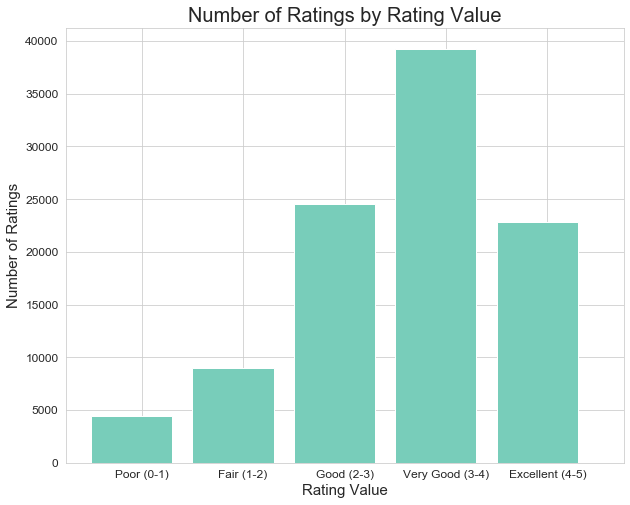

In [34]:
# Exploratory Analysis

ratingsdf = ratingsdf.sort_values('sortOrder',ascending=True)

plt.figure(figsize=[10,8])
plt.hist(ratingsdf['scale'],width=0.8,align='left',bins=range(6),color='#78CDBA')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Rating Value',fontsize=15)
plt.ylabel("Number of Ratings",fontsize=15)
plt.title('Number of Ratings by Rating Value',fontsize=20)
plt.show()

In [17]:
expinfodf_by_genre = expinfodf_by_genre.sort_values(by='Movie_Count_Genre',ascending=False)
expinfodf_by_genre.head(25)

,Genre,Movie_Count_Genre,Average_Revenue,Average_Budget,Movies_Count_RB,Average_Runtime,Movies_Count_RT
5,Drama,2583,57.97,22.38,2583,115.90,2583
1,Comedy,1851,83.52,28.25,1851,102.35,1851
9,Thriller,1502,83.89,32.36,1502,109.67,1502
7,Action,1414,139.01,49.73,1414,112.91,1414
6,Romance,1013,66.88,21.38,1013,113.57,1013
3,Adventure,957,205.00,63.87,957,113.04,957
8,Crime,861,69.92,27.98,861,110.95,861
11,Science Fiction,634,152.31,52.35,634,107.97,634
13,Horror,586,50.86,16.38,586,98.58,586
2,Family,530,195.56,57.99,530,98.24,530


Text(0.5, 1.0, 'Average Profit By Genre')

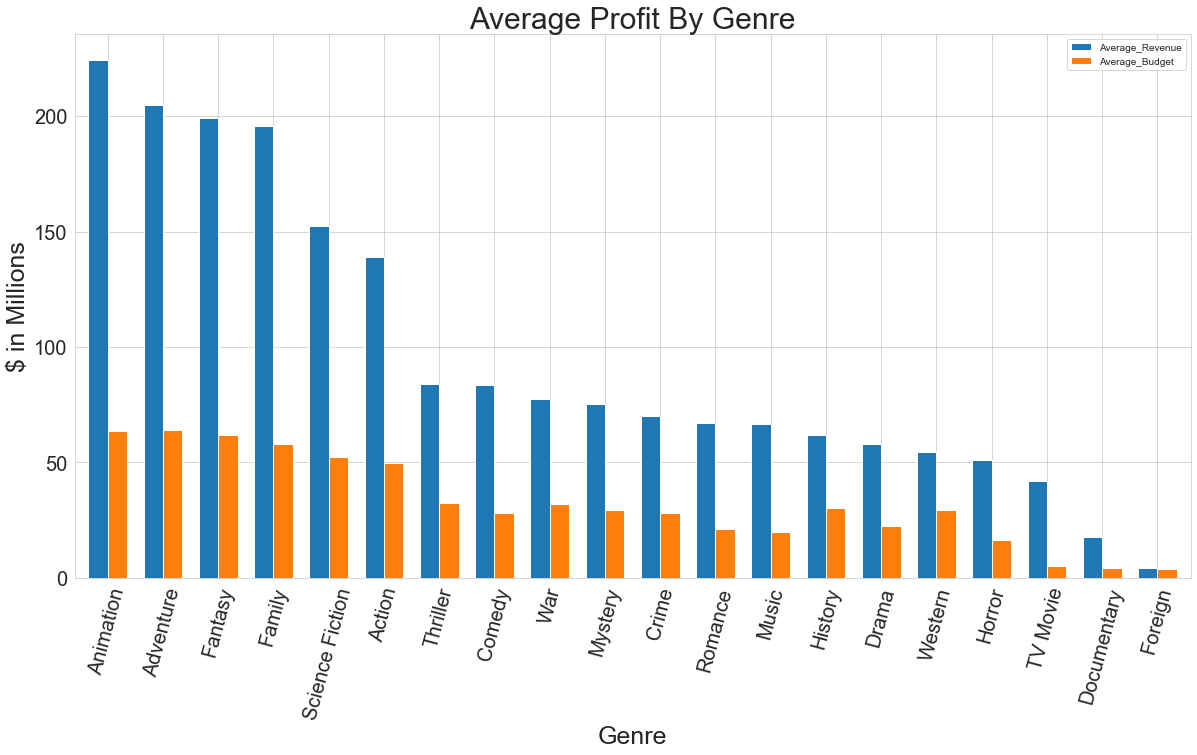

In [9]:
expinfodf_by_genre = expinfodf_by_genre.sort_values(by='Average_Revenue',ascending=False)
f,ax=plt.subplots(figsize=(20, 10))
chart = expinfodf_by_genre[["Genre","Average_Revenue","Average_Budget"]].plot.bar(x='Genre',width=0.7,rot=75,ax=ax,fontsize=20)
chart.set_ylabel("$ in Millions",fontsize=25)
chart.set_xlabel("Genre", fontsize=25)
chart.set_title("Average Profit By Genre",fontsize=30)


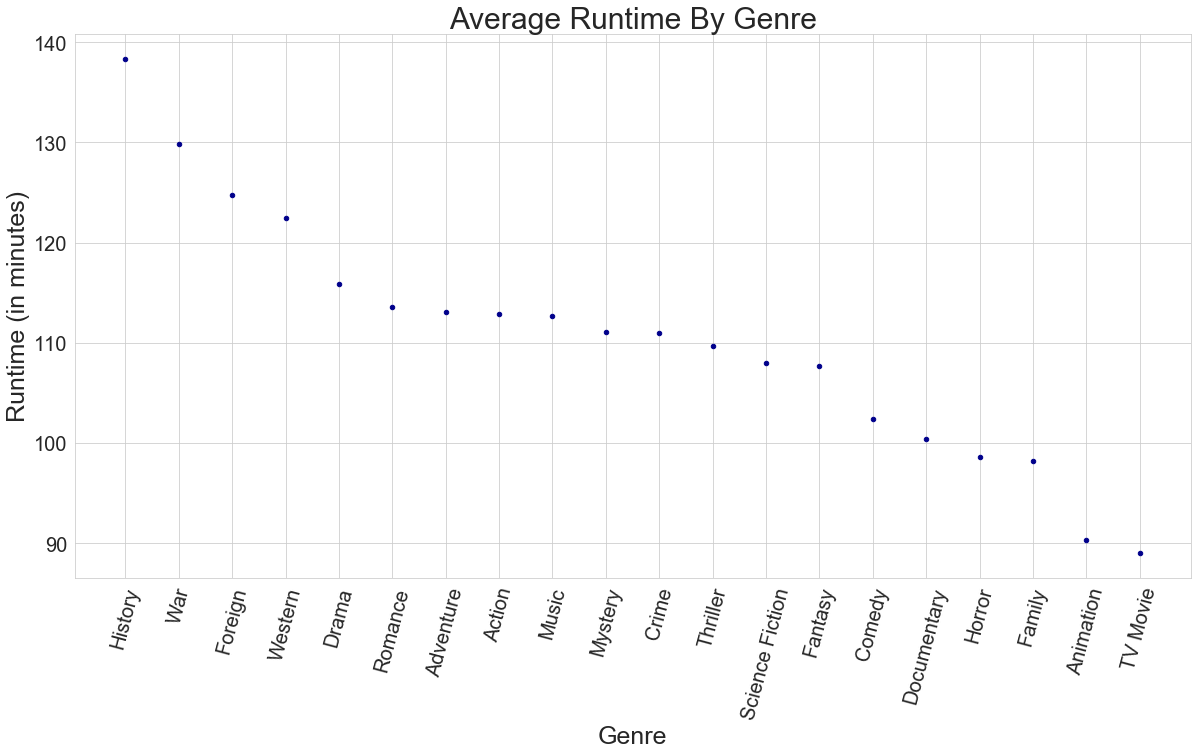

In [10]:
expinfodf_by_genre = expinfodf_by_genre.sort_values(by='Average_Runtime',ascending=False)
f,ax=plt.subplots(figsize=(20, 10))
expinfodf_by_genre.plot(kind="scatter",x='Genre',y='Average_Runtime',ax=ax,c='DarkBlue')
plt.yticks(fontsize=20)
plt.xticks(rotation=75,fontsize=20)
plt.xlabel('Genre',fontsize=25)
plt.ylabel("Runtime (in minutes)",fontsize=25)
plt.title('Average Runtime By Genre',fontsize=30)
plt.show()

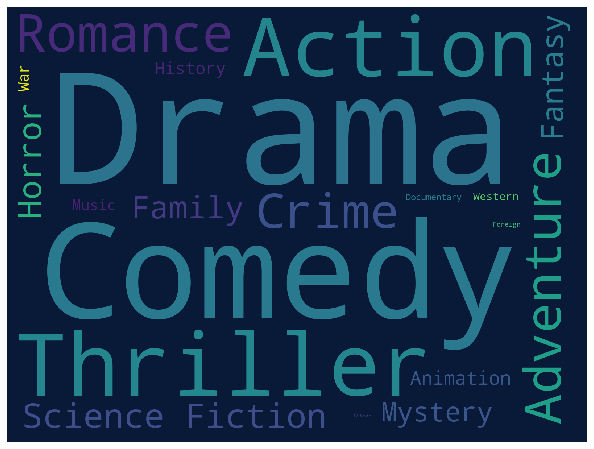

In [11]:
def get_moviescount_for_wordcloud(df):
    return df.set_index('Genre').to_dict()['Movie_Count_Genre']

# wordcloud of genres by count of movies per genre
def wordcloud_for_moviescountbygenre(df):
    w=WordCloud(background_color="#081A37",margin=20,width=800,height=600,prefer_horizontal=0.7,max_words=50,scale=2)
    count = get_moviescount_for_wordcloud(df)
    w.generate_from_frequencies(count)
    f, ax = plt.subplots(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(w)
    plt.show()
    
expinfodf_by_genre = expinfodf_by_genre.sort_values(by='Movie_Count_Genre',ascending=False)
wordcloud_for_moviescountbygenre(expinfodf_by_genre)

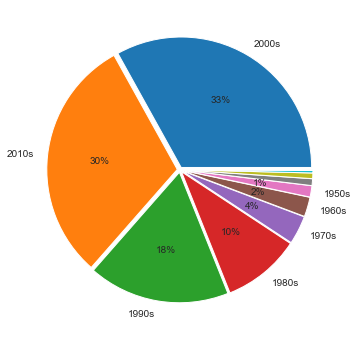

In [14]:
# numbers of movies released in each decade
def count_decade_pie(series):
    counts=series.value_counts()
    counts=counts/counts.sum()
    labels=['' if num<0.01 else str(year) for (year,num) in counts.items()]
    f, ax = plt.subplots(figsize=(6, 6))
    explode = [0.02 if counts.iloc[i] < 100 else 0.001 for i in range(counts.size)]
    plt.pie(counts,labels=labels,autopct=lambda x:'{:1.0f}%'.format(x) if x > 1 else '',explode=explode)
    plt.show()

def countofmovies_decade_pie(df):
    count_decade_pie(df.release_date.dropna().apply(lambda x:str(x.year//10*10)+'s'))
    
countofmovies_decade_pie(movies_cbr_small)

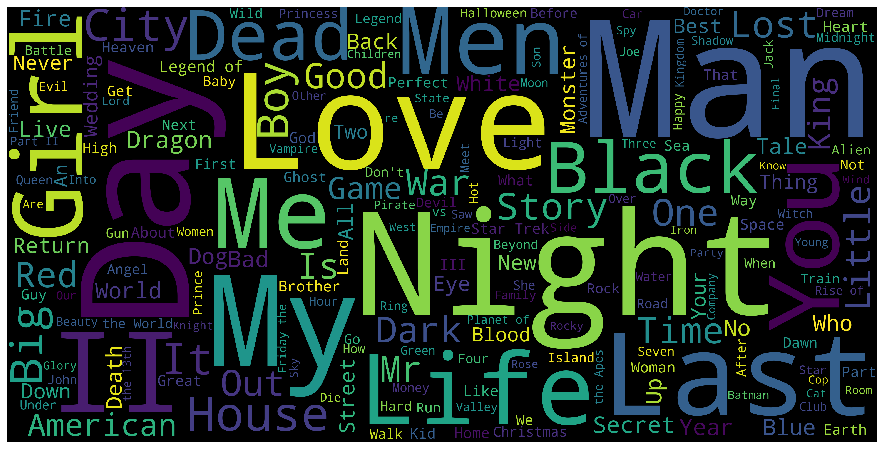

In [16]:
# Create a wordcloud of the movie titles
movies_cbr_small['title'] = movies_cbr_small['title'].fillna("").astype('str')
title_corpus = ' '.join(movies_cbr_small['title']).replace("The","").replace("Movie","")
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()